# Предиктор результатов футбольных матчей

In [13]:
#importing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn # эти строки должны идти перед импортом sklearn
patch_sklearn()                     # для ускорения работы

from sklearn.model_selection    import train_test_split, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics            import accuracy_score, roc_auc_score, RocCurveDisplay, auc, roc_curve
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import LabelBinarizer
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.inspection         import permutation_importance

from catboost import CatBoostClassifier, Pool, metrics

import shap

from itertools import cycle

from joblib import dump

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Обзор данных

In [14]:
data = pd.read_csv("data.csv").drop(['odds_open_tm25', 'odds_open_tb25'], axis=1)
data.head()

,idmatch,odds_open_win1,odds_open_draw,odds_open_win2,vi_win_home,vi_win_away,vi_nolose_home,vi_nolose_away,vi_over25_home,vi_over25_away,...,team2_away_xgpower_03_draw_xga90index,team2_away_xgpower_03_draw_xgsubxgaindex,team2_away_xgpower_03_cop_xg90index,team2_away_xgpower_03_cop_xga90index,team2_away_xgpower_03_cop_xgsubxgaindex,team2_away_xgpower_03_com_xg90index,team2_away_xgpower_03_com_xga90index,team2_away_xgpower_03_com_xgsubxgaindex,result_finish_match,result_total_match
0,39231,2.53,3.15,3.02,2.255,-4.318,19.259,-3.855,-41.798,-10.410,...,0.98,0.40,2.13,4.88,0.44,0.55,2.79,0.20,2.0,0.0
1,39232,2.16,3.26,3.66,-13.230,-29.496,4.164,-47.122,-43.926,-4.662,...,1.23,0.36,0.00,0.00,0.00,0.51,1.34,0.38,1.0,0.0
2,39233,2.35,3.16,3.31,-35.270,-1.048,-17.721,-2.781,8.467,-6.808,...,0.87,0.31,0.00,0.17,0.00,0.00,0.00,0.00,3.0,1.0
3,39235,2.50,3.25,2.97,17.593,27.970,1.079,10.260,-27.452,-23.279,...,1.99,0.05,0.00,0.00,0.00,0.18,0.80,0.22,3.0,1.0
4,45425,2.15,3.49,3.46,19.656,-22.231,-8.999,-8.685,7.560,-7.321,...,0.64,1.45,3.35,1.40,2.40,0.73,2.48,0.29,1.0,1.0


In [15]:

with open("raw_data_info.txt", mode='w') as df_info:
    data.info(verbose=True, show_counts=True, buf=df_info)
print('\nБаланс классов\n')
print(data['result_finish_match'].value_counts(), '\n')
print(data['result_total_match'].value_counts())



Баланс классов

1.0    24763
3.0    17585
2.0    15099
Name: result_finish_match, dtype: int64 

0.0    29307
1.0    28140
Name: result_total_match, dtype: int64


Классы более или менее сбалансированны.

## Предобработка

Оставим для обучения и теста только данные, удовлетворяющие условию `selection` (см. код ниже).  Nan-строки долой. На обучение выделяем 50% данных, остальное -- тест, который далее прредится фильтром `selection_test`.

Увеличим обучающий датасет вдвое, продублировав все строки таким образом, чтобы столбцы, отвечающие за одни и те же параметры для разных команд, поменялись местами. У одинаковых матчей одинаковые id, поэтому для кросс-валидации используем GroupKFold, чтобы никакие два матча не попали одновременно в обучающую и валидационную выборки.

In [16]:
# Для решения задачи пригодными считаем лишь данные, для которых коэффициенты "odds_open_win2" > 2.0 и "odds_open_win1" > 2.0
selection_common = (data["odds_open_win2"] > 2.0) & (data["odds_open_win1"] > 2.0)
selection_test = (data["odds_open_win2"] > 2.6) & (data["odds_open_win1"] > 2.6)

data_selected = data[selection_common].dropna()
data_selected.shape

(29410, 622)

In [17]:
# Делим на трейн и тест
y_finish = data_selected['result_finish_match'].astype(int)
y_result = data_selected['result_total_match'].astype(int) # на это пока не смотрим
X = data_selected.drop(['result_finish_match', 'result_total_match'], axis=1)
X.iloc[1:, :].astype('float32', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y_finish, test_size=0.5, random_state=42, shuffle=True, stratify=y_finish)

X_test, y_test = X_test[selection_test], y_test[selection_test]

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (14705, 620) (14705,)
Test:  (1242, 620) (1242,)


Boolean Series key will be reindexed to match DataFrame index.


In [18]:
# Дублируем данные и переставляем местами пары столбцы следующих видов: 
# "...-2" и "...", 
# "team1..." и "team2...", 
# "...win1" и "...win2" 

def swap(feature_name_1, feature_names_2, train_copy):
    X_train_copy[feature_name_1], X_train_copy[feature_names_2] = X_train_copy[feature_names_2], X_train_copy[feature_name_1]


X_train_copy = X_train.copy(deep=True)
swap('odds_open_win1', 'odds_open_win2', X_train_copy)

for name_2 in X_train_copy.filter(like="-2").columns:  # колонки с паттерном "-2"
    name_1 = ''.join(name_2.split("-2"))  # композиция split и join выделяет из строки подстроку без "-2"
    swap(name_1, name_2, X_train_copy)

for name_2 in X_train_copy.filter(like="team2").columns:  # колонки с паттерном "team2"
    tmp = ''.join(name_2.split("team2"))
    name_1 = 'team1' + tmp  # композиция split и join выделяет из строки подстроку без "team2", слева приписывается "team1"
    swap(name_1, name_2, X_train_copy)


X_train = pd.concat((X_train, X_train_copy))
y_train = pd.concat((y_train, y_train))

In [19]:
groups_train, groups_test = X_train['idmatch'], X_test['idmatch']
X_train.drop('idmatch', axis=1, inplace=True)
X_test.drop('idmatch', axis=1, inplace=True)

X_train.shape, y_train.shape

((29410, 619), (29410,))

In [20]:
# для визуализации результатов сделаем бинаризацию классов: 
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(1242, 3)

## Вспомогательные функции

In [47]:
def find_best_model(model, X_train, y_train, groups_train, params_grid, scoring, n_iter=0):
    """
    Функция подбора гиперпараметров
    """

    if n_iter:
        search = RandomizedSearchCV(
            model, params_grid, n_iter=n_iter,
            scoring=scoring,
            cv=StratifiedGroupKFold(n_splits=5),
            n_jobs=-1
        )
    else:
        search = GridSearchCV(
        model, params_grid,
        scoring=scoring,
        cv=StratifiedGroupKFold(n_splits=5),
        n_jobs=-1
        )

    search.fit(X_train, y_train, groups=groups_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", search.best_params_)

    # Print the best score
    print("Best cross-val score:", search.best_score_)

    return search.best_estimator_


def display_roc_curves(probas, auc, target_names):
    """
    Отображает микро-усреднённую ROC кривую, а так же ROC-кривые по каждому из классов
    :probas: предсказанные вероятности классов
    :auc: Area Under the Curve ROC (macro)
    :target_names: имена классов
    """

    fig, ax = plt.subplots(figsize=(6, 6))

    fpr_micro, tpr_micro, _ = roc_curve(y_onehot_test.ravel(), probas.ravel())
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {auc:.2f})",
        color='m',
        linestyle=":",
        linewidth=3,
    )

    n_classes = probas.shape[1]
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            probas[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.grid()
    plt.show()


def test_and_save(estimator, name, X_test, y_test, groups_test):
    """
    Прогоняет обученную модель по тестовой выборке и сохраняет результаты в файл с именем "name_results.csv" 
    в виде таблицы со столбцами: idmatch, истинные классы, предсказания, коэффициенты уверенности (3 столбца), вер-ть победы 1, вер-ть ничьей, вер-ть победы 2, 
    а также сохраняет саму модель.
    """

    y_pred = np.ravel(estimator.predict(X_test))
    probas = estimator.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc  = roc_auc_score(y_test, probas, average='micro', multi_class='ovr')

    print("Accuracy: ", round(accuracy, 3))
    print("ROC AUC (macro):  ", round(roc_auc, 3))

    table = pd.DataFrame({
        'result_finish_match': y_test,
        'result_finish_match_prediction': y_pred,
        'proba_win_1': probas[:, 0],
        'proba_draw': probas[:, 1],
        'proba_win_2': probas[:, 2]
        }, index=groups_test)
    
    # сохраняем таблицу с результатами теста
    table.to_csv(name + '_results.csv')
    
    # сохраняем модель
    dump(estimator, name + '_estimator.joblib')

    display_roc_curves(probas, roc_auc, ('win_1', 'draw', 'win_2'))

    return table
    

## Логистическая регрессия

In [22]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='newton-cholesky',
    n_jobs=-1
)

params = {"C": np.logspace(-6, 2, 6)}

print("Логистическая регрессия (метрика accuracy)")
log_reg_best = find_best_model(log_reg, X_train, y_train, groups_train, params, scoring='accuracy')

Логистическая регрессия (метрика accuracy)
Best hyperparameters: {'C': 1e-06}
Best cross-val score: 0.3731383883032982


Accuracy:  0.378
ROC AUC (macro):   0.554


X does not have valid feature names, but LogisticRegression was fitted with feature names
invalid value encountered in cast


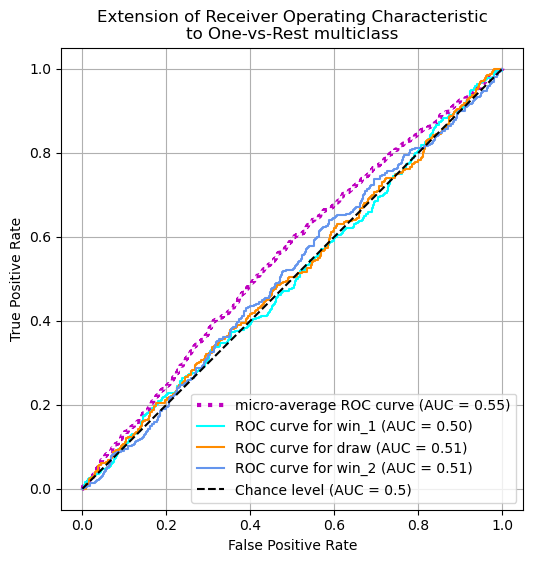

In [48]:
log_reg_results = test_and_save(log_reg_best, 'logistic_1', X_test, y_test, groups_test)

**Вывод:** не сильно лучше рандомайзера.

## Решающее дерево

In [24]:
params = {
    'max_depth': range(5, 15, 3),
    'min_samples_split' : range(400, 1001, 20)
}

tree = DecisionTreeClassifier(random_state=42)

print("Решающее дерево (метрика accuracy)")
tree_best = find_best_model(tree, X_train, y_train, groups_train, params, scoring='accuracy')

Решающее дерево (метрика accuracy)
Best hyperparameters: {'max_depth': 5, 'min_samples_split': 860}
Best cross-val score: 0.3660999659979599


Accuracy:  0.389
ROC AUC (macro):   0.552


invalid value encountered in cast


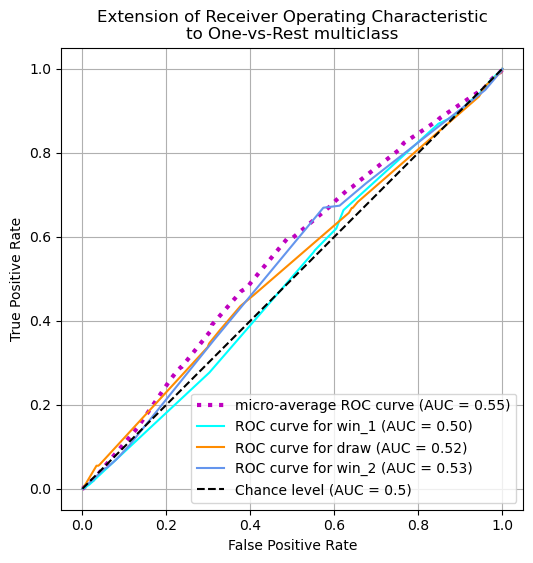

In [49]:
tree_results = test_and_save(tree_best, 'tree_1', X_test, y_test, groups_test)

**Вывод:** почти 0.39 -- неплохо.

## Случайный лес

In [51]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=-1, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

Accuracy:  0.393
ROC AUC (macro):   0.559


invalid value encountered in cast


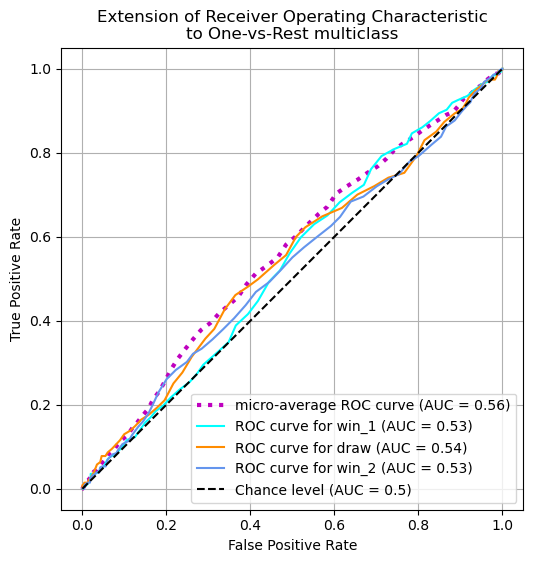

In [52]:
forest_results = test_and_save(forest, 'forest_1', X_test, y_test, groups_test)

Важности признаков в модели случайного леса.

In [28]:
def visualize_feature_importances(model_name, importances_mean, importances_std=None, features=None):

    max = importances_mean.max()

    model_importances = pd.Series(importances_mean, index=features)

    fig, ax = plt.subplots(figsize=(17, 5))
    model_importances.plot.bar(yerr=importances_std, ax=ax)
    ax.set_title(model_name)
    ax.set_ylabel(f"Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

In [29]:
perm_imps_forest = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=43, n_jobs=-1
)

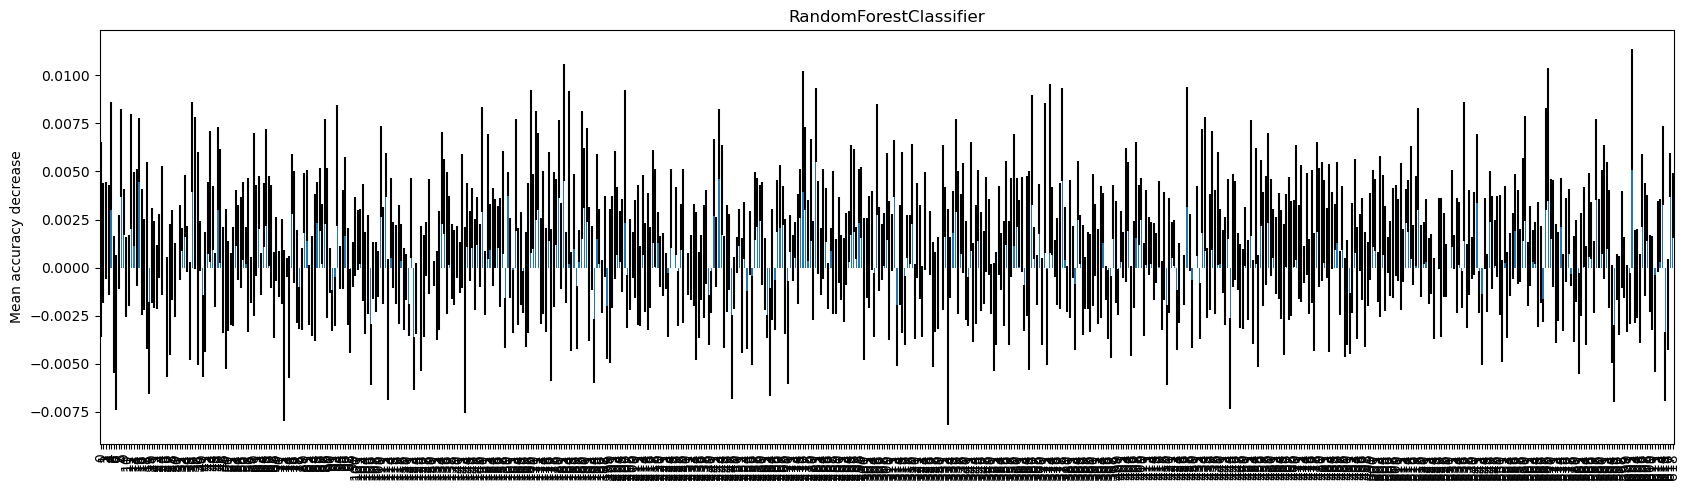

In [30]:
visualize_feature_importances(
    'RandomForestClassifier',
    perm_imps_forest.importances_mean, 
    perm_imps_forest.importances_std
)

Видно, что есть признаки, для которых `mean_accuracy_decrease` отрицательно. Т. е. Удаление этих признаков из датасета может повысить точность. Удалим все, для которых важность не превосходит 0.3 от максимального значения.

In [31]:
good_features = X_test.columns[perm_imps_forest.importances_mean + perm_imps_forest.importances_std > perm_imps_forest.importances_mean.max() * 0.3]

X_test_small, X_train_small = X_test[good_features], X_train[good_features]

X_test_small.shape, X_train_small.shape

((1242, 363), (29410, 363))

In [32]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=-1, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train_small, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

Accuracy:  0.3639291465378422
ROC AUC (macro):   0.5526318519037136


invalid value encountered in cast


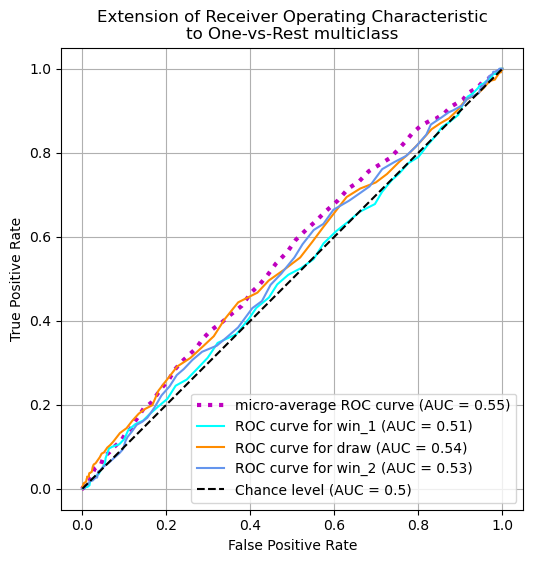

In [33]:
forest_results = test_and_save(forest, 'forest_2', X_test_small, y_test, groups_test)

**Вывод:** со всеми признаками лучше

## CatBoost

In [34]:
# создадим пуллы
train_pool = Pool(X_train, y_train)
test_pool  = Pool(X_test,  y_test)

In [35]:
# самая простая
CB_model = CatBoostClassifier(
    iterations=10000,
    loss_function="MultiClass",
    use_best_model=True,
    eval_metric=metrics.Accuracy(),
    verbose=250,
    early_stopping_rounds=250
    )

CB_model.fit(train_pool, eval_set=test_pool)

Learning rate set to 0.04794
0:	learn: 0.3739204	test: 0.3711755	best: 0.3711755 (0)	total: 388ms	remaining: 1h 4m 39s
250:	learn: 0.4903774	test: 0.3872786	best: 0.3969404 (77)	total: 44.7s	remaining: 28m 57s
500:	learn: 0.5848011	test: 0.3840580	best: 0.3993559 (275)	total: 1m 28s	remaining: 27m 57s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.3993558776
bestIteration = 275

Shrink model to first 276 iterations.


Accuracy:  0.399
ROC AUC (macro):   0.566


invalid value encountered in cast


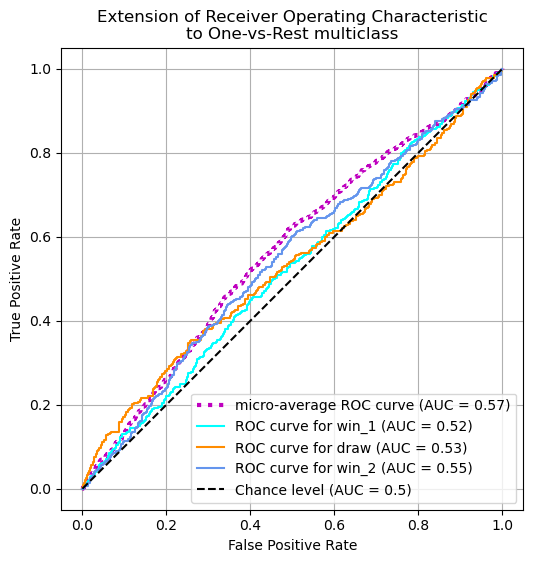

In [53]:
CB_results = test_and_save(CB_model, 'catboost', X_test, y_test, groups_test)

**Вывод:** градиентный бустинг и лес справились почти одинаково.

Посчитаем и выведем в файл `catboost_importances.txt` важности признаков в порядке убывания, а также визуализируем 50 самых "важных".

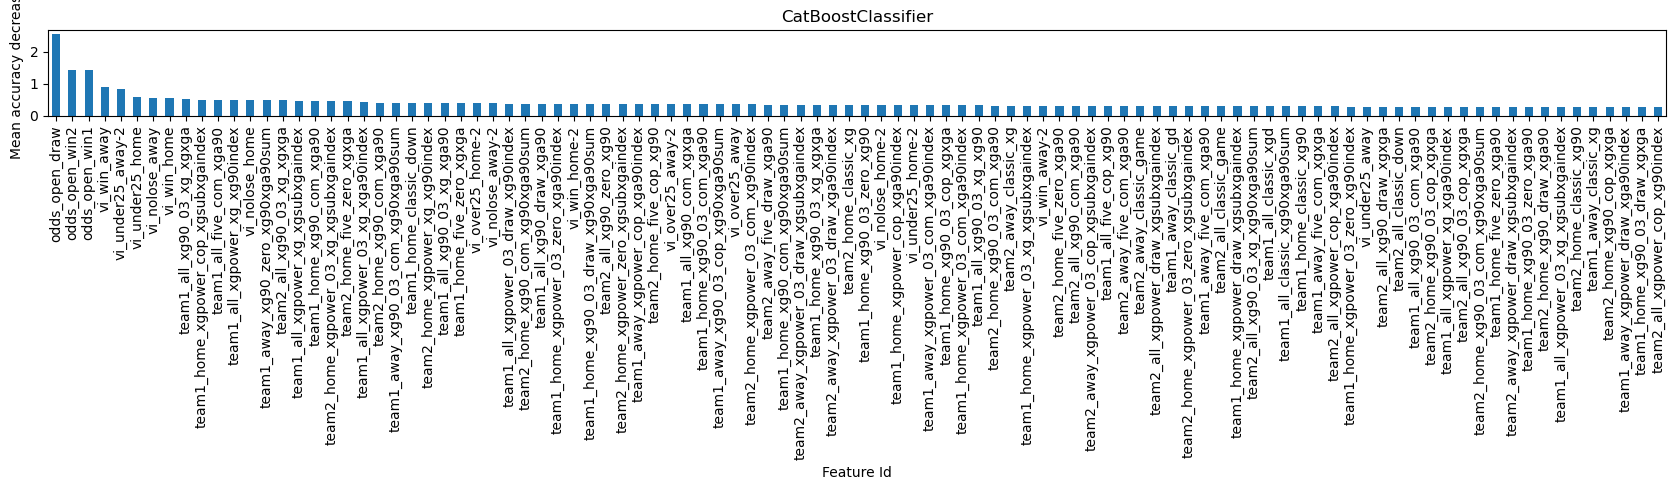

In [37]:
feature_inportances = CB_model.get_feature_importance(train_pool, prettified=True)
feature_inportances.to_csv('catboost_importances.txt')

# сколько признаков визуализировать
n_features_show = 100
# из DataFrame делаем Series
feature_inportances_pdSeries = pd.Series(
    feature_inportances['Importances'].iloc[:n_features_show].values, 
    index=feature_inportances['Feature Id'].iloc[:n_features_show]
    )

visualize_feature_importances(
    'CatBoostClassifier', 
    feature_inportances_pdSeries, 
    features=feature_inportances_pdSeries.index)

Для наглядной интерпретации работы модели может быть полезно применить методы из [этой](https://uproger.com/obyasnite-lyubuyu-model-mashinnogo-obucheniya-na-python-s-pomoshhyu-shap/) статьи. Ниже изображён пример для матча c `id` 32815.

In [38]:
print("Истина:", y_test.iloc[1])
print("Предсказание", CB_model.predict(X_test.iloc[1, :])[0])
print('"Псевдо-вероятности":', CB_model.predict(X_test.iloc[1, :], prediction_type="RawFormulaVal"))
print("Вероятности:         ", CB_model.predict_proba(X_test.iloc[1, :]))

Истина: 1
Предсказание 1
"Псевдо-вероятности": [ 0.26214392 -0.15267674 -0.10946718]
Вероятности:          [0.42551723 0.28103656 0.29344621]


In [39]:
explainer = shap.Explainer(CB_model)
shap_values = explainer(X_test)

In [40]:
shap.initjs()
print('Class "win1"')
shap.plots.force(shap_values[1, :, 0])

Class "win1"


In [41]:
print('Class "draw"')
shap.plots.force(shap_values[1, :, 1])

Class "draw"


In [42]:
print('Class "win2"')
shap.plots.force(shap_values[1, :, 2])

Class "win2"


**Пояснение:** чёрные числа -- то что на самом деле предсказывает модель, перед тем, как специальная функция преобразует их к вероятностям, то есть засовывает в интервал от 0 до 1. Например, первый график означает, что в предсказание 0.12 (читай "в вероятность 0.29") наибольший вклад внесли признаки, подписаннные синим. Цвет вроде бы ничего особо не означает. Подробнее по ссылке выше. Не знаю, насколько это полезно, но если что, то такие штуки можно нарисовать для каждого матча. 

**Вывод:** CatBoost действительно сработал получше, но всё равно плохо. Можно сказать, что данные собраны при помощи генератора случайных чисел.